# Wealth Distribution Analysis


In [4]:
import pandas as pd
import numpy as np
from prettytable import PrettyTable
import matplotlib.pyplot as plt
from ast import literal_eval

In [2]:
# Step 1. Loading Dataset

# Load the dataset
file_path = 'IOTA_1year_tx_data2.csv'
df = pd.read_csv(file_path)

# Convert the 'timestamp' column to a datetime object
df['timestamp'] = pd.to_datetime(df['timestamp'])

# Step 2. Calculation 

# Function to safely parse the strings
def safe_literal_eval(val):
    try:
        return literal_eval(val)
    except (ValueError, SyntaxError):
        return []

In [5]:
# Prepare Data: Calculate net balances for each address
def calculate_net_balances(transactions):
    address_balances = {}
    
    for _, tx in transactions.iterrows():
        input_addresses = safe_literal_eval(tx['input_addresses_x'])
        output_addresses = safe_literal_eval(tx['output_addresses_y'])
        input_amounts = safe_literal_eval(tx['input_amounts_x'])
        output_amounts = safe_literal_eval(tx['output_amounts_y'])

        for addr, amount in zip(input_addresses, input_amounts):
            if addr in address_balances:
                address_balances[addr] -= amount
            else:
                address_balances[addr] = -amount

        for addr, amount in zip(output_addresses, output_amounts):
            if addr in address_balances:
                address_balances[addr] += amount
            else:
                address_balances[addr] = amount

    return address_balances

address_balances = calculate_net_balances(df)

# Convert the address balances to a DataFrame
balances_df = pd.DataFrame(list(address_balances.items()), columns=['address', 'balance'])
balances_df = balances_df[balances_df['balance'] > 0]  # Filter out addresses with zero or negative balance

# Add the original transaction timestamps
df_balances_with_timestamps = pd.merge(balances_df, df[['timestamp']], left_index=True, right_index=True, how='left')

In [6]:
# Assuming balances_df is already calculated and contains 'balance' column

# Step 1: Calculate dynamic balance ranges based on actual data
num_intervals = 7
min_balance = balances_df['balance'].min()
max_balance = balances_df['balance'].max()

# Generate logarithmically spaced balance ranges
balance_ranges = np.logspace(np.log10(min_balance), np.log10(max_balance), num=num_intervals)

# Step 2: Initialize lists to store the results
balance_range_labels = []
num_addresses = []
percentage_of_wealth = []
percentage_of_addresses = []

# Step 3: Calculate total wealth and total number of addresses
total_wealth = balances_df['balance'].sum()
total_addresses = len(balances_df)

# Step 4: Calculate statistics for each balance range
for i in range(len(balance_ranges) - 1):
    lower = balance_ranges[i]
    upper = balance_ranges[i + 1]
    
    # Check for invalid balance ranges (like $0.00 & < $0.00) and skip them
    if lower == 0 and upper == 0:
        continue

    # Create a label for each balance range
    label = f'{lower:,.2f} & < {upper:,.2f}'
    
    # Filter addresses in the current balance range
    in_range = (balances_df['balance'] >= lower) & (balances_df['balance'] < upper)
    
    # Count number of addresses and calculate wealth in this range
    num_addresses_in_range = in_range.sum()
    wealth_in_range = balances_df.loc[in_range, 'balance'].sum()
    
    # Avoid 0% for positive numbers by ensuring a minimum percentage
    min_percentage = 0.0001  # A minimum threshold of 0.0001% to avoid displaying 0.0000% for positive values
    
    percentage_wealth = max((wealth_in_range / total_wealth) * 100, min_percentage) if num_addresses_in_range > 0 else 0
    percentage_addresses = max((num_addresses_in_range / total_addresses) * 100, min_percentage) if num_addresses_in_range > 0 else 0
    
    # Skip the first problematic row by checking if the balance range is effectively zero
    if lower == 0 and upper == 0:
        continue  # Skip the first row where balance is zero
    
    # Append the results to the respective lists
    balance_range_labels.append(label)
    num_addresses.append(num_addresses_in_range)
    percentage_of_wealth.append(percentage_wealth)
    percentage_of_addresses.append(percentage_addresses)

# Add final range for balances above the max balance range
label = f'>= ${balance_ranges[-1]:,.2f}'
in_range = (balances_df['balance'] >= balance_ranges[-1])
num_addresses_in_range = in_range.sum()
wealth_in_range = balances_df.loc[in_range, 'balance'].sum()

percentage_wealth = max((wealth_in_range / total_wealth) * 100, min_percentage) if num_addresses_in_range > 0 else 0
percentage_addresses = max((num_addresses_in_range / total_addresses) * 100, min_percentage) if num_addresses_in_range > 0 else 0

balance_range_labels.append(label)
num_addresses.append(num_addresses_in_range)
percentage_of_wealth.append(percentage_wealth)
percentage_of_addresses.append(percentage_addresses)

# Step 5: Create a PrettyTable to display the results
table = PrettyTable()
table.field_names = ["IOTA Tokens", "Number of Addresses", "Percentage of Wealth", "Percentage of Addresses"]

# Step 6: Add rows with 4-digit rounding
for i in range(len(balance_range_labels)):
    table.add_row([balance_range_labels[i], num_addresses[i], f"{percentage_of_wealth[i]:.4f}%", f"{percentage_of_addresses[i]:.4f}%"])

# Step 7: Print the table
print(table)

+----------------------------------------------------+---------------------+----------------------+-------------------------+
|                    IOTA Tokens                     | Number of Addresses | Percentage of Wealth | Percentage of Addresses |
+----------------------------------------------------+---------------------+----------------------+-------------------------+
|                   0.00 & < 0.00                    |          4          |       0.0001%        |         0.0028%         |
|                   0.00 & < 0.87                    |          0          |       0.0000%        |         0.0000%         |
|                 0.87 & < 9,376.85                  |         1591        |       0.0001%        |         1.0991%         |
|            9,376.85 & < 101,238,605.04             |        47322        |       0.0070%        |         32.6906%        |
|      101,238,605.04 & < 1,093,037,749,834.92       |        95623        |       6.4244%        |         66.0576%  

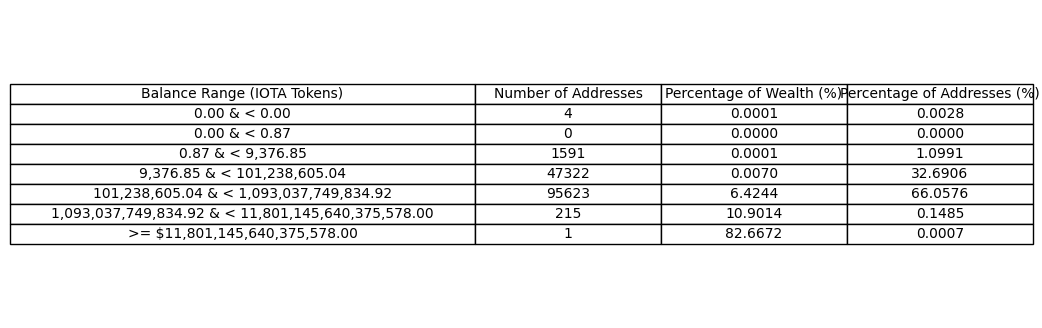

In [7]:
# Step 5: Create a DataFrame to display the table more cleanly
df_table = pd.DataFrame({
    'Balance Range (IOTA Tokens)': balance_range_labels,
    'Number of Addresses': num_addresses,
    'Percentage of Wealth (%)': [f"{x:.4f}" for x in percentage_of_wealth],
    'Percentage of Addresses (%)': [f"{x:.4f}" for x in percentage_of_addresses]
})

# Step 6: Plotting the table with Matplotlib for high-quality output
fig, ax = plt.subplots(figsize=(12, 4))  # Increased width to 12 to avoid text overflow
ax.axis('off')
ax.axis('tight')

# Create the table with readable font size
table = ax.table(cellText=df_table.values, colLabels=df_table.columns, cellLoc='center', loc='center')

# Adjust the font size and column widths for better readability
table.auto_set_font_size(False)
table.set_fontsize(10)
table.scale(1.2, 1.2)  # Scaled up for better fitting of the text

# Adjust the width of specific columns to avoid content spilling
col_widths = {0: 0.5, 1: 0.2, 2: 0.2, 3: 0.2}  # Adjust column widths if needed
for key, cell in table.get_celld().items():
    cell.set_width(col_widths.get(key[1], 0.15))  # Set default width for unspecified columns

# Save as a high-quality image file
plt.savefig("IOTA_Wealth_Distribution_Table_High_Quality.png", dpi=300)

# Display the table
plt.show()